In [1]:
# so we can access classes from parent directory
import sys
sys.path.append("..")

In [22]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
import caption_featurizers                              # for getting caption representations
import color_featurizers                                # for getting color representations
from experiment import FeatureHandler                   # for combining caption and color features

from models import PytorchModel, LiteralSpeaker         # model base that handles training / evaluation

In [104]:
import importlib
import models
importlib.reload(models)
from models import PytorchModel, LiteralSpeaker

In [59]:
# get data
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [4]:
# define feature functions
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.CharacterTokenizer)

#    use fourier representation from the hsv space and normalize all hsv values to be between 0 and 1
color_phi = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "hsv", normalized=True)

In [60]:
# speaker's target is to predict tokens following the SOS token
def speaker_target(data_entry):
    _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target
# pass in train and dev data, our caption and color feature functions, function for turning an element of our data
# (train or dev) into the target, and we only care the target (which is the first color) so we aren't going to mess that up
# by randomizing the order of the colors
# we aren't going to use the dev data to train the model, but we'll still include it in the feature handler
feature_handler = FeatureHandler(train_data, dev_data, caption_phi, color_phi, target_fn=speaker_target, randomized_colors=False)

In [9]:
X_train = feature_handler.train_features()
y_train = feature_handler.train_targets()

In [12]:
# modify training data to only include representation of the target color
for i in range(len(X_train)):
    X_train[i][1] = X_train[i][1][:1]

[[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  3,  7,  4,  9, 10, 11,  3,  4,
         12, 13,  3, 14]),
  array([[ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
          -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
           0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
          -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
           0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
          -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
          -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
           0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
           0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
          -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
           0.6280306 , -0.81116533,  0.6033464 , -0.34218323],
         [ 1.        , -0.97922283,  0.91775465, -0.97624546,  0.91202444,
        

In [10]:
# now would be where we define the model:
import torch
from torch import nn
import numpy as np

In [29]:
class CharacterCaptionGenerator(nn.Module):
    
    def __init__(self, color_in_dim, color_dim, vocab_size, embed_dim, speaker_hidden_dim):
        super(CharacterCaptionGenerator, self).__init__()
        
        # for colors
        self.color_encoder = nn.Linear(color_in_dim, color_dim)
        
        # for text
        self.embed = nn.Embedding(vocab_size, embed_dim)
        
        self.speaker_lstm = nn.LSTM(embed_dim + color_dim, speaker_hidden_dim, batch_first=True)
        self.linear = nn.Linear(speaker_hidden_dim, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        
    def forward(self, color, captions):
        color_features = self.color_encoder(color)
        caption_features = self.embed(captions)
        
        # concatenate color features to the embedding of each token
        color_features = color_features.repeat(1, captions.shape[1], 1) # repeat for number of tokens
        inputs = torch.cat((caption_features, color_features), dim=2) # concatenate along the innermost dimension
        
        # just use teacher forcing here for now (i.e. don't feed predictions back into network some percentage of the time
        #). Not doing this leads to greater instability but is cleaner to implement
        hiddens, _ = self.speaker_lstm(inputs)
        outputs = self.linear(hiddens)
        output_norm = self.logsoftmax(outputs)
        return output_norm
        

In [30]:
# We'll use the LiteralSpeaker model to train this, so we can also use it to sample
character_s0 = LiteralSpeaker(CharacterCaptionGenerator, optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)
character_s0.init_model(color_in_dim=54, color_dim=50, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                       embed_dim=50, speaker_hidden_dim=100)

In [31]:
character_s0.fit(X_train, y_train)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0040
0m 7s (0:1000 7.90%) 1.2626
0m 15s (0:2000 15.79%) 1.0561
0m 22s (0:3000 23.69%) 1.1210
0m 30s (0:4000 31.58%) 1.0533
0m 37s (0:5000 39.48%) 1.2429
0m 44s (0:6000 47.37%) 0.9419
0m 50s (0:7000 55.27%) 0.8195
0m 57s (0:8000 63.17%) 0.9987
1m 3s (0:9000 71.06%) 0.7682
1m 10s (0:10000 78.96%) 0.8468
1m 15s (0:11000 86.85%) 0.7774
1m 21s (0:12000 94.75%) 0.7639
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0846325772181153
---EPOCH 1---
1m 29s (1:0 0.00%) 0.0008
1m 35s (1:1000 7.90%) 0.7962
1m 42s (1:2000 15.79%) 0.9179
1m 50s (1:3000 23.69%) 1.0049
1m 58s (1:4000 31.58%) 0.9811
2m 5s (1:5000 39.48%) 1.1845
2m 13s (1:6000 47.37%) 0.8742
2m 19s (1:7000 55.27%) 0.7783
2m 26s (1:8000 63.17%) 0.9589
2m 35s (1:9000 71.06%) 0.7332
2m 43s (1:10000 78.96%) 0.8115
2m 49s (1:11000 86.85%) 0.7515
2m 56s (1:12000 94.75%) 0.7491
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0550731394762793
---EPOCH 2---
3m 7s (2:0 0.00%) 0.0008
3m 15s (2:1000 7.90%) 0.7814
3m 23s

In [33]:
# save trained model
character_s0.save_model("../model/character_literal_speaker.params")

In [61]:
X_assess = feature_handler.test_features()
y_assess = feature_handler.test_targets()

In [62]:
for i in range(len(X_assess)):
    X_assess[i][1] = X_assess[i][1][:1]

In [63]:
%%time
predictions = character_s0.predict(X_assess, sample=1, beam_width=1)

CPU times: user 44.8 s, sys: 3.61 s, total: 48.4 s
Wall time: 45.3 s


In [64]:
predictions[:10]

[array([[ 0,  9,  7, 12, 21, 13, 14]]),
 array([[ 0, 19, 12, 10,  5, 14]]),
 array([[ 0, 15, 11,  7, 15, 10,  3, 14]]),
 array([[ 0,  9, 10, 11,  3, 14]]),
 array([[ 0, 12,  7,  6, 13, 19,  3, 14]]),
 array([[ 0, 15, 11,  7, 15, 10,  3, 14]]),
 array([[ 0, 19,  7,  3,  3, 13, 14]]),
 array([[ 0, 19,  7,  3,  3, 13, 14]]),
 array([[ 0, 19,  7,  3,  3, 13, 14]]),
 array([[ 0, 19,  7,  3,  3, 13, 14]])]

In [42]:
def wordify(idx_array):
    return "".join([feature_handler.caption_featurizer.caption_indexer.get_word_from_idx(i) for i in idx_array[0]])

In [65]:
pred_words = [wordify(p) for p in predictions]

In [76]:
for i, w in zip(range(50), pred_words[198:198+50]):
    print("{}) {}".format(i, w))

0) <sos>green<eos>
1) <sos>gray<eos>
2) <sos>green<eos>
3) <sos>green<eos>
4) <sos>green<eos>
5) <sos>yellow<eos>
6) <sos>pink<eos>
7) <sos>blue<eos>
8) <sos>green<eos>
9) <sos>blue<eos>
10) <sos>gold gold<eos>
11) <sos>blue<eos>
12) <sos>green<eos>
13) <sos>blue<eos>
14) <sos>blue<eos>
15) <sos>yellow<eos>
16) <sos>green<eos>
17) <sos>orange<eos>
18) <sos>purple<eos>
19) <sos>gray<eos>
20) <sos>red<eos>
21) <sos>blue<eos>
22) <sos>blue<eos>
23) <sos>green<eos>
24) <sos>gray<eos>
25) <sos>brown<eos>
26) <sos>grey<eos>
27) <sos>blue<eos>
28) <sos>red<eos>
29) <sos>green<eos>
30) <sos>blue<eos>
31) <sos>green<eos>
32) <sos>brown<eos>
33) <sos>green<eos>
34) <sos>purple<eos>
35) <sos>green<eos>
36) <sos>green<eos>
37) <sos>green<eos>
38) <sos>green<eos>
39) <sos>blue<eos>
40) <sos>green<eos>
41) <sos>green<eos>
42) <sos>brown<eos>
43) <sos>green<eos>
44) <sos>red<eos>
45) <sos>green<eos>
46) <sos>green<eos>
47) <sos>orange<eos>
48) <sos>blue<eos>
49) <sos>gray<eos>


48) Game: 2641-2 Round: 49
the pinker pink


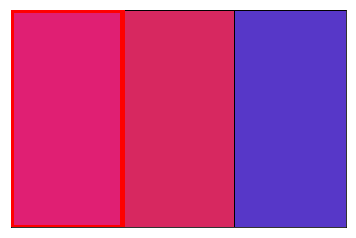

In [98]:
dev_data.display_game(48)

# Model 2

But do we really need the fourier representation? Can we learn directly from the RGB or HSV values?

First, let's try hsv:

In [77]:
color_phi_hsv = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_id, "hsv", normalized=True) # identity feature function
feature_handler_hsv = FeatureHandler(train_data, dev_data, caption_phi, color_phi_hsv, target_fn=speaker_target, randomized_colors=False)

X_train_hsv = feature_handler_hsv.train_features()
y_train_hsv = feature_handler_hsv.train_targets()

# extract only first color
for i in range(len(X_train_hsv)):
    X_train_hsv[i][1] = X_train_hsv[i][1][:1]

In [105]:
character_s0_hsv = LiteralSpeaker(CharacterCaptionGenerator, optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, max_gen_len=40)
character_s0_hsv.init_model(color_in_dim=3, color_dim=50, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                       embed_dim=50, speaker_hidden_dim=100)

In [79]:
character_s0_hsv.fit(X_train_hsv, y_train_hsv)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0040
0m 5s (0:1000 7.90%) 1.2797
0m 13s (0:2000 15.79%) 1.0488
0m 21s (0:3000 23.69%) 1.1079
0m 29s (0:4000 31.58%) 1.0386
0m 37s (0:5000 39.48%) 1.2098
0m 45s (0:6000 47.37%) 0.9223
0m 51s (0:7000 55.27%) 0.8195
0m 58s (0:8000 63.17%) 0.9668
1m 5s (0:9000 71.06%) 0.7581
1m 11s (0:10000 78.96%) 0.8149
1m 16s (0:11000 86.85%) 0.7632
1m 22s (0:12000 94.75%) 0.7455
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0638111662144463
---EPOCH 1---
1m 31s (1:0 0.00%) 0.0007
1m 36s (1:1000 7.90%) 0.7711
1m 44s (1:2000 15.79%) 0.8834
1m 51s (1:3000 23.69%) 0.9630
1m 59s (1:4000 31.58%) 0.9450
2m 6s (1:5000 39.48%) 1.1091
2m 13s (1:6000 47.37%) 0.8456
2m 19s (1:7000 55.27%) 0.7569
2m 26s (1:8000 63.17%) 0.9135
2m 32s (1:9000 71.06%) 0.7160
2m 39s (1:10000 78.96%) 0.7743
2m 44s (1:11000 86.85%) 0.7242
2m 50s (1:12000 94.75%) 0.7091
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 0.9907468994781375
---EPOCH 2---
2m 58s (2:0 0.00%) 0.0007
3m 4s (2:1000 7.90%) 0.7342
3m 11s

In [82]:
#character_s0_hsv.save_model("../model/character_literal_speaker_hsv.params")

In [106]:
character_s0_hsv.load_model("../model/character_literal_speaker_hsv.params")

In [81]:
X_assess_hsv = feature_handler_hsv.test_features()

for i in range(len(X_assess_hsv)):
    X_assess_hsv[i][1] = X_assess_hsv[i][1][:1]

In [107]:
predictions_hsv = character_s0_hsv.predict(X_assess_hsv, sample=1, beam_width=1)

In [108]:
pred_words_hsv = [wordify(p) for p in predictions_hsv]

In [109]:
pred_words_hsv[:50]

['<sos>grey<eos>',
 '<sos>brown<eos>',
 '<sos>pick the two pick the two pick the two p',
 '<sos>blue<eos>',
 '<sos>orange<eos>',
 '<sos>pick the two pick the two pick the two p',
 '<sos>green<eos>',
 '<sos>green<eos>',
 '<sos>green<eos>',
 '<sos>yellow<eos>',
 '<sos>gray<eos>',
 '<sos>green<eos>',
 '<sos>brown<eos>',
 '<sos>yellow<eos>',
 '<sos>gray<eos>',
 '<sos>grey<eos>',
 '<sos>blue<eos>',
 '<sos>red<eos>',
 '<sos>green<eos>',
 '<sos>red<eos>',
 '<sos>blue<eos>',
 '<sos>grey<eos>',
 '<sos>blue<eos>',
 '<sos>red<eos>',
 '<sos>grey<eos>',
 '<sos>green<eos>',
 '<sos>blue<eos>',
 '<sos>green<eos>',
 '<sos>gray<eos>',
 '<sos>gray<eos>',
 '<sos>green<eos>',
 '<sos>yellow<eos>',
 '<sos>green<eos>',
 '<sos>red<eos>',
 '<sos>blue<eos>',
 '<sos>blue<eos>',
 '<sos>brown<eos>',
 '<sos>brown<eos>',
 '<sos>green<eos>',
 '<sos>grey<eos>',
 '<sos>blue<eos>',
 '<sos>pink<eos>',
 '<sos>purple<eos>',
 '<sos>red<eos>',
 '<sos>gray<eos>',
 '<sos>blue<eos>',
 '<sos>green<eos>',
 '<sos>grey<eos>',
 '<sos

In [89]:
pred_words[:10]

['<sos>brown<eos>',
 '<sos>gold<eos>',
 '<sos>purple<eos>',
 '<sos>blue<eos>',
 '<sos>orange<eos>',
 '<sos>purple<eos>',
 '<sos>green<eos>',
 '<sos>green<eos>',
 '<sos>green<eos>',
 '<sos>green<eos>']

In [94]:
sum(np.array(pred_words) == np.array(pred_words_hsv))/len(pred_words)

0.5914486279514997

In [137]:
# count number of non-sensical ones:
np.shape(np.nonzero(np.array([not pw.endswith("<eos>") for pw in pred_words])))

(1, 16)

In [134]:
pred_words[10820]

'<sos>pick the pick the pi'

In [139]:
# count number of non-sensical ones:
np.nonzero(np.array([not pw.endswith("<eos>") for pw in pred_words_hsv]))

(array([    2,     5,    67,    70,    82,    96,   144,   145,   146,
          180,   182,   204,   264,   282,   303,   354,   401,   418,
          422,   439,   444,   467,   484,   488,   528,   554,   561,
          574,   583,   643,   645,   656,   664,   668,   695,   713,
          744,   751,   752,   773,   777,   783,   810,   828,   867,
          877,   878,   919,   992,  1014,  1015,  1019,  1020,  1051,
         1068,  1112,  1149,  1157,  1221,  1234,  1247,  1263,  1268,
         1279,  1301,  1303,  1305,  1318,  1341,  1368,  1383,  1401,
         1412,  1413,  1434,  1456,  1465,  1466,  1477,  1488,  1490,
         1507,  1508,  1517,  1561,  1567,  1583,  1587,  1621,  1638,
         1642,  1646,  1687,  1702,  1723,  1736,  1748,  1766,  1778,
         1787,  1794,  1834,  1869,  1917,  1921,  1926,  1939,  1946,
         1971,  2000,  2002,  2009,  2022,  2033,  2037,  2056,  2089,
         2092,  2105,  2113,  2122,  2144,  2223,  2228,  2243,  2264,
      

In [149]:
pred_words_hsv[10330]

'<sos>pick the bright pink<eos>'

10330) Game: 6856-2 Round: 13
pink


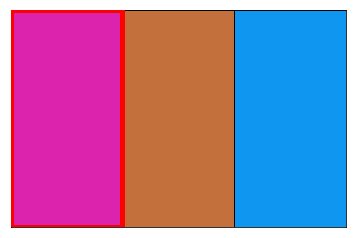

In [150]:
dev_data.display_game(10330)

In [148]:
np.nonzero(np.array(["pink" in pw for pw in pred_words_hsv]))

(array([   41,    48,    60,    85,   103,   164,   277,   320,   329,
          390,   423,   436,   442,   455,   463,   493,   496,   508,
          619,   634,   672,   729,   758,   786,   814,   829,   841,
          843,   958,  1081,  1108,  1158,  1176,  1181,  1190,  1214,
         1218,  1233,  1337,  1409,  1433,  1478,  1515,  1571,  1591,
         1610,  1622,  1682,  1797,  1812,  1951,  1966,  1989,  2059,
         2062,  2063,  2103,  2207,  2208,  2282,  2324,  2347,  2401,
         2467,  2475,  2498,  2529,  2576,  2591,  2598,  2616,  2672,
         2754,  2764,  2768,  2770,  2834,  2840,  2886,  2903,  2920,
         3011,  3089,  3090,  3167,  3171,  3199,  3257,  3260,  3297,
         3353,  3413,  3462,  3464,  3504,  3514,  3516,  3533,  3589,
         3656,  3669,  3700,  3741,  3760,  3764,  3786,  3791,  3814,
         3829,  3857,  3865,  3897,  3902,  3942,  3977,  3991,  4052,
         4067,  4101,  4126,  4180,  4212,  4213,  4293,  4356,  4380,
      

So that kind of worked. 60% of the predictions were the same between hsv and fourier. There were 16 failed utterances (utterances that didn't end in 20 characters) in fourier. Mostly seem to be gray or orange.

while 842 to that didn't finish under hsv. Pink seems to be a problem, maybe because Pick and Pink start with the same letters? Sometimes it works though, so maybe with more training we could get it.

# Model 3

But do we really need the fourier representation? Can we learn directly from the RGB or HSV values?

Now let's try rgb

In [151]:
color_phi_rgb = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_id, "rgb", normalized=True) # identity feature function
feature_handler_rgb = FeatureHandler(train_data, dev_data, caption_phi, color_phi_hsv, target_fn=speaker_target, randomized_colors=False)

X_train_rgb = feature_handler_rgb.train_features()
y_train_rgb = feature_handler_rgb.train_targets()

# extract only first color
for i in range(len(X_train_rgb)):
    X_train_rgb[i][1] = X_train_rgb[i][1][:1]

In [152]:
character_s0_rgb = LiteralSpeaker(CharacterCaptionGenerator, optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, max_gen_len=40)
character_s0_rgb.init_model(color_in_dim=3, color_dim=50, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                       embed_dim=50, speaker_hidden_dim=100)

In [153]:
character_s0_rgb.fit(X_train_rgb, y_train_rgb)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0040
0m 5s (0:1000 7.90%) 1.3086
0m 12s (0:2000 15.79%) 1.0490
0m 20s (0:3000 23.69%) 1.1015
0m 28s (0:4000 31.58%) 1.0290
0m 35s (0:5000 39.48%) 1.2058
0m 43s (0:6000 47.37%) 0.9113
0m 49s (0:7000 55.27%) 0.8171
0m 56s (0:8000 63.17%) 0.9596
1m 2s (0:9000 71.06%) 0.7558
1m 9s (0:10000 78.96%) 0.8157
1m 15s (0:11000 86.85%) 0.7687
1m 21s (0:12000 94.75%) 0.7392
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0477882915834587
---EPOCH 1---
1m 30s (1:0 0.00%) 0.0007
1m 37s (1:1000 7.90%) 0.7568
1m 45s (1:2000 15.79%) 0.8692
1m 53s (1:3000 23.69%) 0.9674
2m 1s (1:4000 31.58%) 0.9290
2m 9s (1:5000 39.48%) 1.1096
2m 17s (1:6000 47.37%) 0.8407
2m 23s (1:7000 55.27%) 0.7546
2m 31s (1:8000 63.17%) 0.9042
2m 38s (1:9000 71.06%) 0.7133
2m 44s (1:10000 78.96%) 0.7681
2m 50s (1:11000 86.85%) 0.7249
2m 56s (1:12000 94.75%) 0.7044
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0121417010625204
---EPOCH 2---
3m 5s (2:0 0.00%) 0.0006
3m 11s (2:1000 7.90%) 0.7254
3m 19s (

In [164]:
character_s0_rgb.save_model("../model/character_literal_speaker_rgb.params")

In [154]:
X_assess_rgb = feature_handler_rgb.test_features()

for i in range(len(X_assess_rgb)):
    X_assess_rgb[i][1] = X_assess_rgb[i][1][:1]

In [155]:
predictions_rgb = character_s0_rgb.predict(X_assess_rgb, sample=1, beam_width=1)

In [156]:
pred_words_rgb = [wordify(p) for p in predictions_rgb]

In [163]:
for i, w in zip(range(50), pred_words_rgb[0:0+50]):
    print("{}) {}".format(i, w))

0) <sos>brown<eos>
1) <sos>green<eos>
2) <sos>redish<eos>
3) <sos>blue<eos>
4) <sos>orange<eos>
5) <sos>pick the pink<eos>
6) <sos>green<eos>
7) <sos>green<eos>
8) <sos>green<eos>
9) <sos>green<eos>
10) <sos>gray<eos>
11) <sos>green<eos>
12) <sos>brown<eos>
13) <sos>yellow<eos>
14) <sos>gray<eos>
15) <sos>purple<eos>
16) <sos>blue<eos>
17) <sos>orange<eos>
18) <sos>green<eos>
19) <sos>orange<eos>
20) <sos>blue<eos>
21) <sos>purple<eos>
22) <sos>blue<eos>
23) <sos>red<eos>
24) <sos>purple<eos>
25) <sos>green<eos>
26) <sos>blue<eos>
27) <sos>green<eos>
28) <sos>gray<eos>
29) <sos>brown<eos>
30) <sos>green<eos>
31) <sos>green<eos>
32) <sos>green<eos>
33) <sos>orange<eos>
34) <sos>blue<eos>
35) <sos>purple<eos>
36) <sos>brown<eos>
37) <sos>brown<eos>
38) <sos>blue<eos>
39) <sos>gray<eos>
40) <sos>blue<eos>
41) <sos>red<eos>
42) <sos>purple<eos>
43) <sos>red<eos>
44) <sos>gray<eos>
45) <sos>blue<eos>
46) <sos>green<eos>
47) <sos>purple<eos>
48) <sos>red<eos>
49) <sos>gray<eos>


0) Game: 2641-2 Round: 1
gray


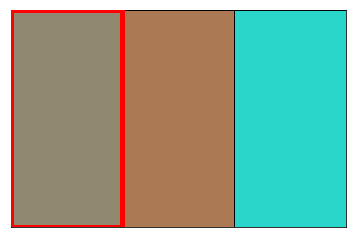

1) Game: 2641-2 Round: 2
green


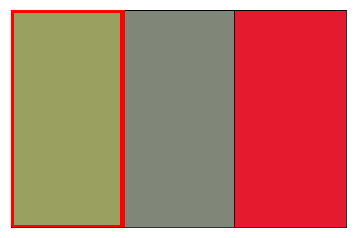

2) Game: 2641-2 Round: 3
lavender ~ the duller one


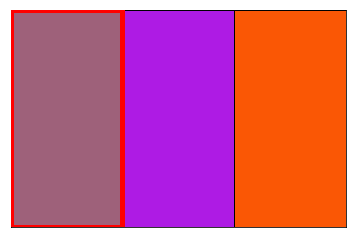

3) Game: 2641-2 Round: 4
the brighter blue


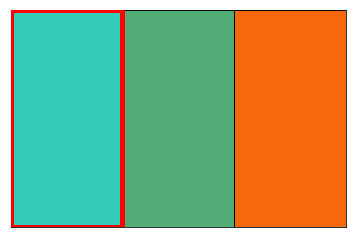

4) Game: 2641-2 Round: 5
yellow


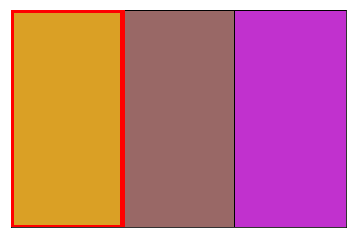

5) Game: 2641-2 Round: 6
the dullest purple


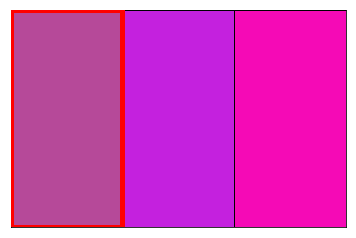

6) Game: 2641-2 Round: 7
green


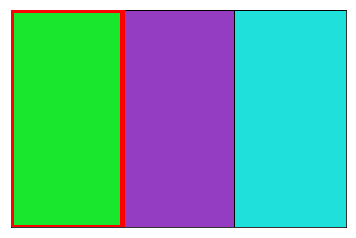

7) Game: 2641-2 Round: 8
green


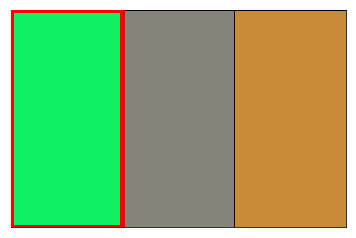

8) Game: 2641-2 Round: 9
the brightest one


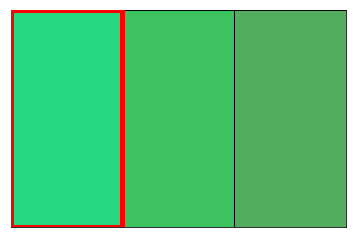

9) Game: 2641-2 Round: 10
green


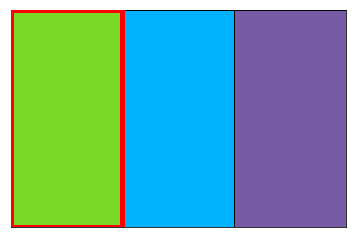

10) Game: 2641-2 Round: 11
dull lavender


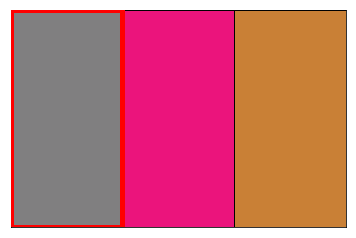

11) Game: 2641-2 Round: 12
the duller aqua


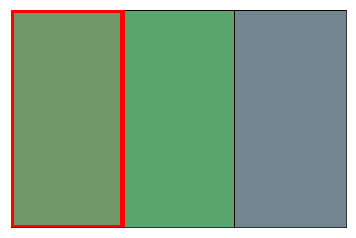

12) Game: 2641-2 Round: 13
the more grey green


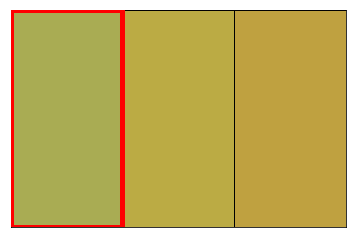

13) Game: 2641-2 Round: 14
yellow


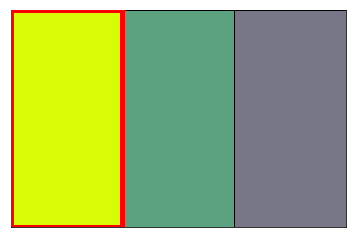

14) Game: 2641-2 Round: 15
the slightly darker lavender


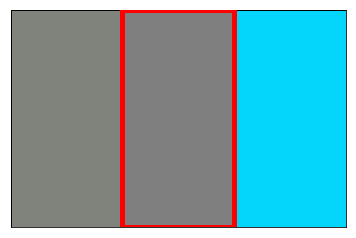

15) Game: 2641-2 Round: 16
the duller purple ~ dullest ~ more purple


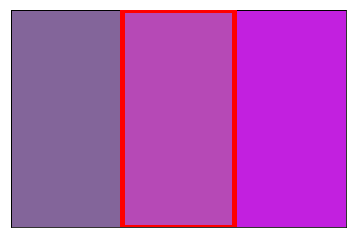

16) Game: 2641-2 Round: 17
blue


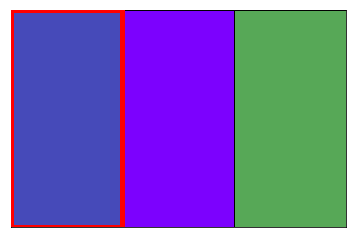

17) Game: 2641-2 Round: 18
red


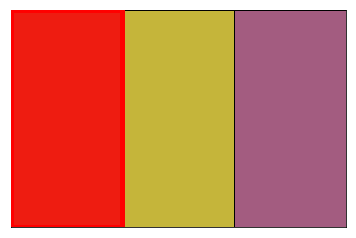

18) Game: 2641-2 Round: 19
the brighter green


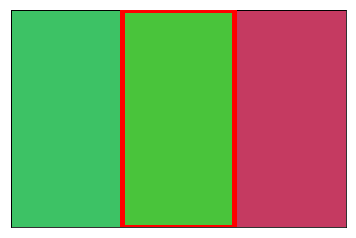

19) Game: 2641-2 Round: 20
orange


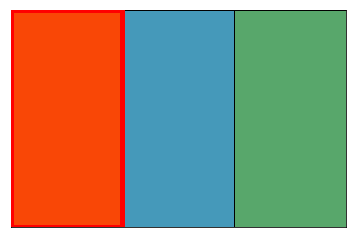

20) Game: 2641-2 Round: 21
the purplish blue


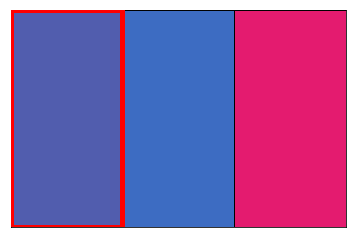

21) Game: 2641-2 Round: 22
lavender


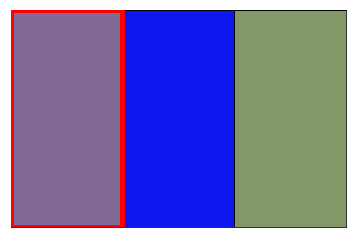

22) Game: 2641-2 Round: 23
blue


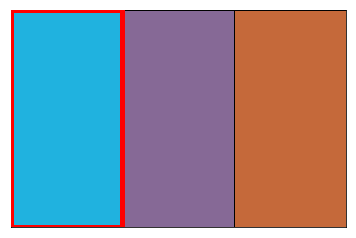

23) Game: 2641-2 Round: 24
pink


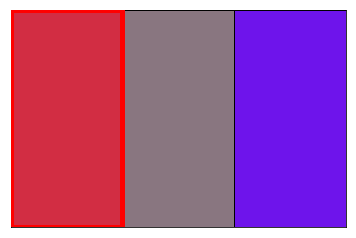

24) Game: 2641-2 Round: 25
the lightest lavender


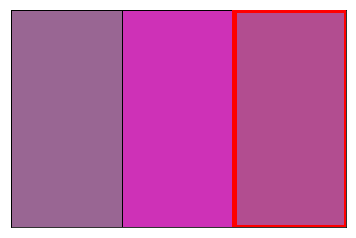

25) Game: 2641-2 Round: 26
the one that looks more yellow, but not greyed out


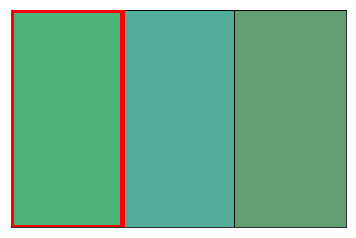

26) Game: 2641-2 Round: 27
the most intense blue


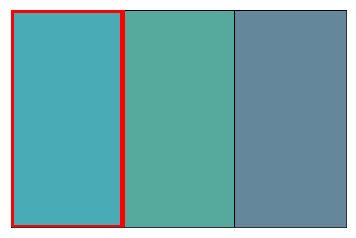

27) Game: 2641-2 Round: 28
the most bright and neon looking


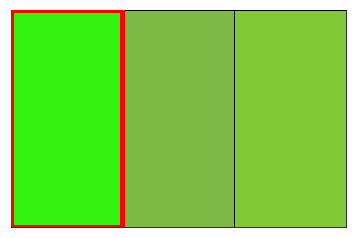

28) Game: 2641-2 Round: 29
the dull lavender that is more purplish


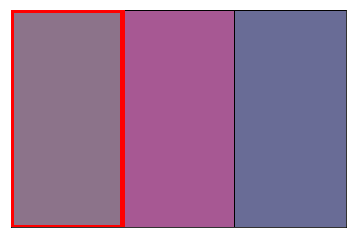

29) Game: 2641-2 Round: 30
the greyish blue that is slightly darker? hard to see ~ the more grey one


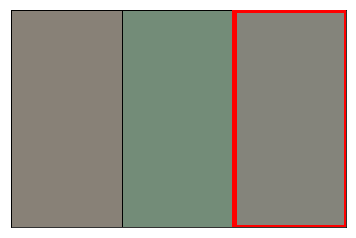

30) Game: 2641-2 Round: 31
the brightest one


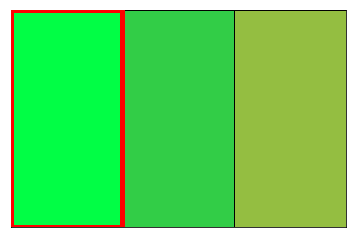

31) Game: 2641-2 Round: 32
the yellowest one


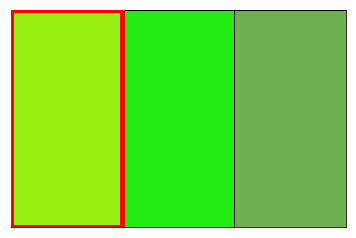

32) Game: 2641-2 Round: 33
green


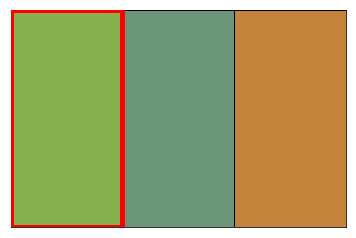

33) Game: 2641-2 Round: 34
brown/orange


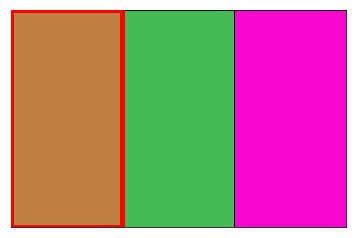

34) Game: 2641-2 Round: 35
blue


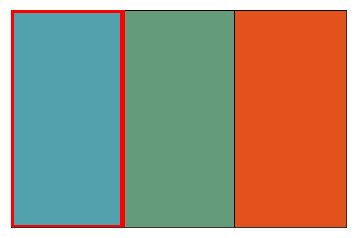

35) Game: 2641-2 Round: 36
the most intense one


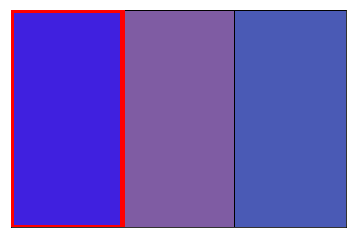

36) Game: 2641-2 Round: 37
the dull slightly bluish lavender


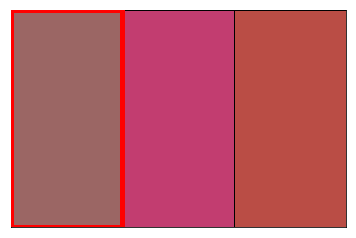

37) Game: 2641-2 Round: 38
grey


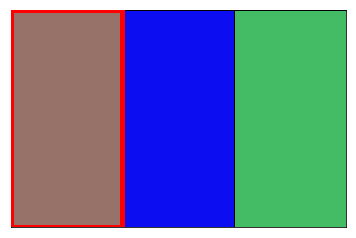

38) Game: 2641-2 Round: 39
bright blue green ~ the lighter one


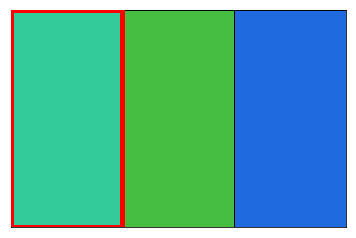

39) Game: 2641-2 Round: 40
the greyest one


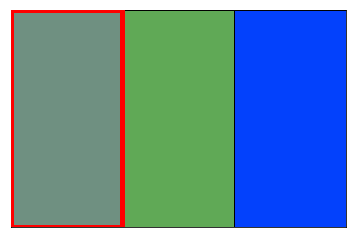

40) Game: 2641-2 Round: 41
the lighter blue


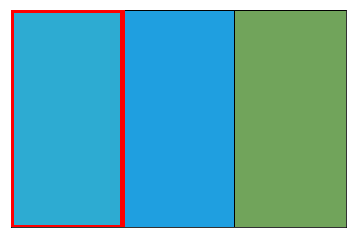

41) Game: 2641-2 Round: 42
pink


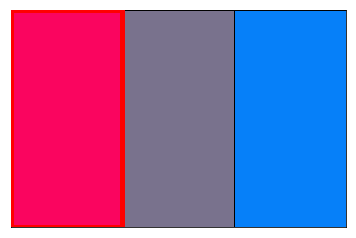

42) Game: 2641-2 Round: 43
the most intense one


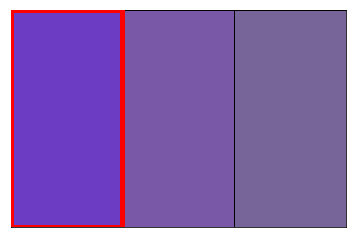

43) Game: 2641-2 Round: 44
red


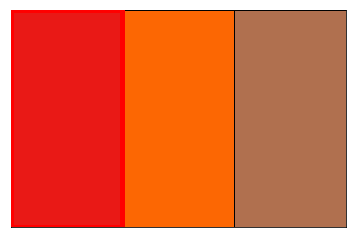

44) Game: 2641-2 Round: 45
the greyish blue


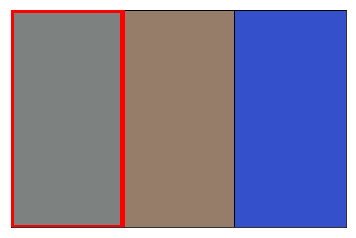

45) Game: 2641-2 Round: 46
blue


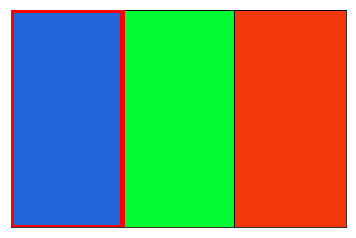

46) Game: 2641-2 Round: 47
the yellower green


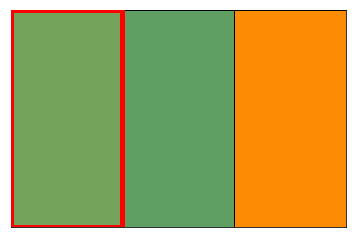

47) Game: 2641-2 Round: 48
the brighter lavender


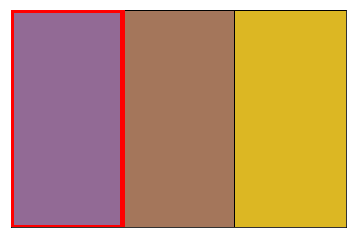

48) Game: 2641-2 Round: 49
the pinker pink


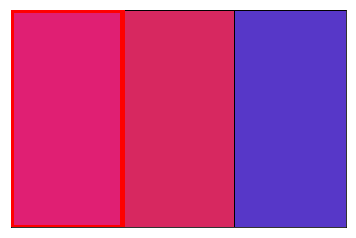

49) Game: 2641-2 Round: 50
the bluer grey


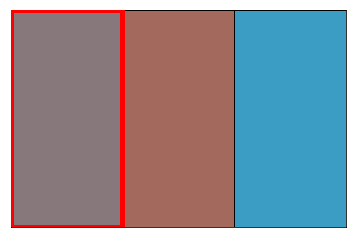

In [160]:
dev_data.display_game_for_gameid("2641-2")

Ok, so this one also seems to be doing pretty well. I like that it got the "ish" for some of the colors. Overall, all three of the methods seem to be doing decently, which is great! The only problem is that "pick" must be more likely than "pink" in some cases, so "pink" turns into "pick"